In [1]:
import numpy as np
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
import matplotlib.pyplot as plt
from sharkfin.population import SharkPopulation, SharkPopulationSolution
from sharkfin.utilities import price_dividend_ratio_random_walk
from simulate.parameters import WHITESHARK, LUCAS0

In [2]:
from sharkfin.expectations import UsualExpectations
from sharkfin.markets import MockMarket

In [3]:
from scipy.optimize import fsolve
import seaborn as sns
import pandas as pd

## Setup

In [4]:
LUCAS0

{'cycles': 0,
 'aNrmInitStd': 1.0,
 'aNrmInitMean': 6,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 1,
 'num_per_type': 1000}

In [5]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983

rng = 23409

market_args = {
    "dividend_growth_rate": dividend_growth_rate,
    "dividend_std": dividend_std,
    "rng": rng,
    "price_to_dividend_ratio": price_dividend_ratio_random_walk(
        LUCAS0["DiscFac"], LUCAS0["CRRA"], dividend_growth_rate, dividend_std
    ),
}

subjective_return: 0.9999130331113283


In [6]:
ue = UsualExpectations(MockMarket(**market_args))
ue.calculate_risky_expectations()
risky_expectations = ue.risky_expectations()

In [7]:
parameter_dict = LUCAS0.copy()

In [8]:
parameter_dict.update(risky_expectations)

In [9]:
PARAMS = parameter_dict # a0h.parameters

PARAMS["aNrmInitMean"] = 1
PARAMS["aNrmInitStd"] = 0.00
PARAMS["T_sim"] = 5000
PARAMS["PermGroFac"] = [PARAMS["PermGroFac"]]
PARAMS["AgentCount"] = 2000
PARAMS["sim_common_Rrisky"] = False

#PARAMS['LivPrb'] = [1.0]

at = SequentialPortfolioConsumerType(**PARAMS)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

In [10]:
parameter_dict

{'cycles': 0,
 'aNrmInitStd': 0.0,
 'aNrmInitMean': 1,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': [1.0],
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 2000,
 'num_per_type': 1000,
 'RiskyAvg': 1.0175492133848216,
 'RiskyStd': 0.09283741339989003,
 'T_sim': 5000,
 'sim_common_Rrisky': False}

## Using the solution functions

In [11]:
cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

In [12]:
def expected_increase(mNrm):
    share = ShareFunc(mNrm)

    aNrm = mNrm - cFunc(mNrm)

    mNrm_next = (
        aNrm
        * (share * at.parameters["RiskyAvg"] + (1 - share) * at.parameters["Rfree"])
        + 1
    )

    gain = mNrm_next - aNrm

    return gain

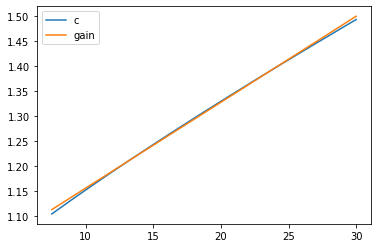

In [13]:
mNrm = np.linspace(7.5, 30, 1000)

plt.plot(mNrm, cFunc(mNrm), label="c")

plt.plot(mNrm, expected_increase(mNrm), label="gain")

plt.legend()

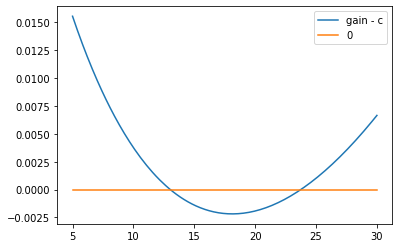

In [14]:
mNrm = np.linspace(5, 30, 1000)

plt.plot(mNrm, expected_increase(mNrm) - cFunc(mNrm), label="gain - c")
plt.plot(mNrm, np.zeros(mNrm.shape), label="0")


plt.legend()

In [15]:
def diff(mNrm):
    return expected_increase(mNrm) - cFunc(mNrm)

m0, m1 = fsolve(diff, [0,50])

In [16]:
m0

13.03029885028313

In [17]:
np.log(m0)

2.5672773264288513

In [18]:
# Transition equations for the consumption stage
def m_nrm_next(shocks, aNrm, Share, Rfree, PermGroFac):
    """
    Given end-of-period balances and contribution share and the
    start-of-next-period shocks, figure out next period's normalized riskless
    assets

    Parameters
    ----------
    shocks : np.array
        Length-3 array with the stochastic shocks that get realized between the
        end of the current period and the start of next period. Their order is
        (0) permanent income shock, (1) transitory income shock, (2) risky
        asset return.
    aNrm : float
        End-of-period risk-free asset balances.
    Share : float
        End-of-period income deduction share.
    Rfree : float
        Risk-free return factor.
    PermGroFac : float
        Permanent income growth factor.

    Returns
    -------
    m_nrm_tp1 : float
        Next-period normalized riskless balance.

    """
    # Extract shocks
    perm_shk = shocks[0]
    tran_shk = shocks[1]

    m_nrm_tp1 = Rfree * aNrm / (perm_shk * PermGroFac) + (1.0 - Share) * tran_shk

    return m_nrm_tp1

In [19]:
#(approximately, working backwards fom m0 to a0...
a0 = (m0 - 1) / at.parameters['Rfree']

In [20]:
at.assign_parameters(aNrmInitMean = np.log(a0)) # np.log(m0))

at.initialize_sim()
at.simulate()

{'aNrm': array([[11.8228177 , 11.8228177 , 11.8228177 , ..., 11.8228177 ,
         11.8228177 , 11.8228177 ],
        [11.77499582, 12.35913918, 12.35913918, ..., 11.77499582,
         11.77499582, 10.375802  ],
        [11.72741209, 13.99243013, 10.84586129, ..., 11.72741209,
         13.33137617, 10.8478682 ],
        ...,
        [ 3.70801705,  5.43034425,  6.1144463 , ..., 22.18597908,
          6.97163709, 28.82685893],
        [ 3.27127231,  5.68712752,  6.93052308, ..., 22.09596881,
          6.62334196, 25.29758048],
        [ 3.27558213,  5.9548941 ,  7.85268132, ..., 25.02102858,
          6.29360739, 28.65049699]]),
 'cNrm': array([[1.20748115, 1.20748115, 1.20748115, ..., 1.20748115, 1.20748115,
         1.20748115],
        [1.20659637, 1.21735484, 1.21735484, ..., 1.20659637, 1.20659637,
         1.18051904],
        [1.205716  , 1.24706857, 1.18932882, ..., 1.205716  , 1.23510569,
         1.18936634],
        ...,
        [1.04872628, 1.08419796, 1.09797199, ..., 1.3894

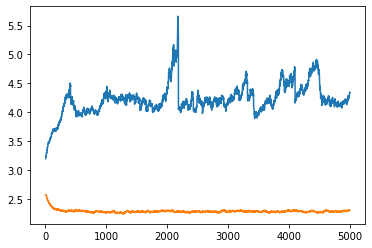

In [21]:
df_mNrm = pd.DataFrame(at.history['mNrm'])

plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)))
plt.plot(np.log(df_mNrm[df_mNrm < m1].mean(axis=1)))

Text(0, 0.5, 'log mNm')

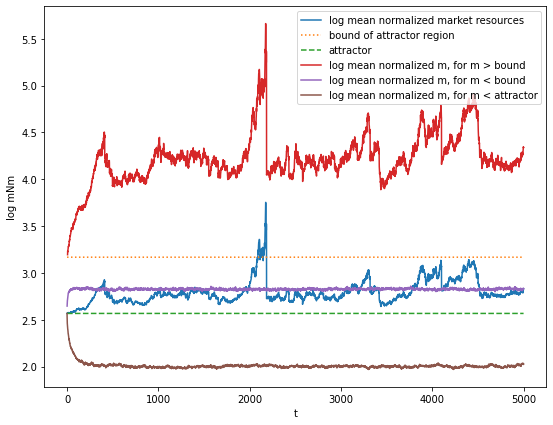

In [80]:
plt.figure(figsize=(9,7))
plt.plot(np.log(np.mean(at.history['mNrm'], axis = 1)), label = "log mean normalized market resources")
plt.plot(np.ones(np.sum(at.history['mNrm'], axis = 1).shape) * np.log(m1), ':', label="bound of attractor region")
plt.plot(np.ones(np.sum(at.history['mNrm'], axis = 1).shape) * np.log(m0), '--', label="attractor")
plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)), label = "log mean normalized m, for m > bound")
plt.plot(np.log(df_mNrm[(df_mNrm > m0) & (df_mNrm < m1)].mean(axis=1)), label = "log mean normalized m, for m < bound")
plt.plot(np.log(df_mNrm[df_mNrm < m0].mean(axis=1)), label = "log mean normalized m, for m < attractor")
plt.legend()
plt.xlabel('t')
plt.ylabel('log mNm')

In [45]:
upper_mNrm = df_mNrm[df_mNrm > m1].sum(axis=1)
middle_mNrm = df_mNrm[(df_mNrm < m1) & (df_mNrm > m0)].sum(axis=1)
lower_mNrm = df_mNrm[df_mNrm < m0].sum(axis=1)
total_mNrm = df_mNrm.sum(axis=1)

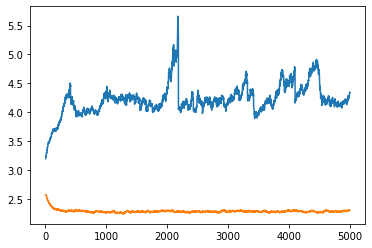

In [25]:
df_mNrm = pd.DataFrame(at.history['mNrm'])

plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)))
plt.plot(np.log(df_mNrm[df_mNrm < m1].mean(axis=1)))

Text(0.5, 1.0, 'Percentage of resources held, by class')

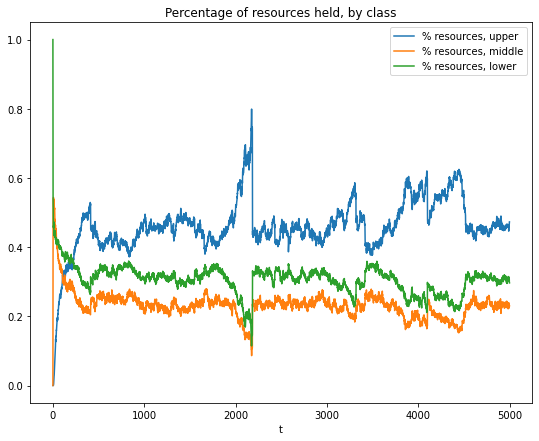

In [58]:
plt.figure(figsize=(9,7))
plt.plot(upper_mNrm / total_mNrm, label="% resources, upper"), '--',
plt.plot(middle_mNrm / total_mNrm, label="% resources, middle"), '--',
plt.plot(lower_mNrm / total_mNrm, label="% resources, lower"), '--',
plt.legend()
plt.xlabel('t')
plt.title('Percentage of resources held, by class')

Text(0.5, 1.0, 'Percentage population, by class')

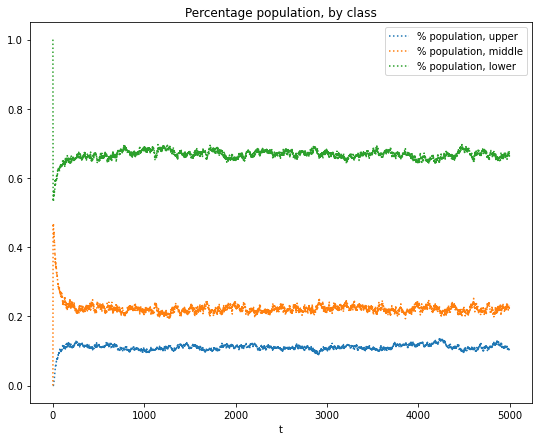

In [57]:
plt.figure(figsize=(9,7))

plt.plot((df_mNrm > m1).sum(axis=1) / at.parameters['AgentCount'], ':',
         label = "% population, upper")

plt.plot(((df_mNrm < m1) & (df_mNrm > m0)).sum(axis=1) / at.parameters['AgentCount'], ':',
         label = "% population, middle")

plt.plot((df_mNrm < m0).sum(axis=1)  / at.parameters['AgentCount'], ':',
         label = "% population, lower")

plt.legend()
plt.xlabel('t')
plt.title("Percentage population, by class")



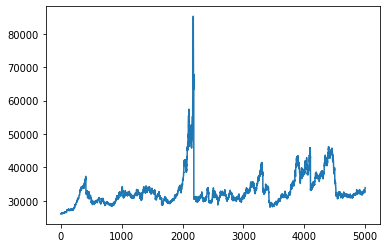

In [59]:
plt.plot(at.history['mNrm'].sum(1))

In [28]:
#sns.lineplot(data = df, x = 't', y='value')

Text(0.5, 6.79999999999999, 'log mNrm')

<Figure size 648x504 with 0 Axes>

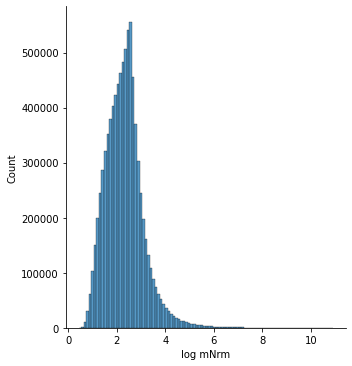

In [79]:
plt.figure(figsize=(9,7))
sns.displot(np.log(at.history['mNrm'][750:,:].flatten()), bins = 100)
plt.xlabel('log mNrm')

In [71]:
np.log([m0, m1])

array([2.56727733, 3.16752382])